In [1]:
from fastai2.vision.all import * 

In [2]:
path = Path("/media/cedricperauer/Datasets/Datasets/imagenette2-160")


In [3]:
path.ls()

(#2) [Path('/media/cedricperauer/Datasets/Datasets/imagenette2-160/train'),Path('/media/cedricperauer/Datasets/Datasets/imagenette2-160/val')]

In [10]:
dblock = DataBlock(blocks=(ImageBlock(),CategoryBlock()), 
        get_items = get_image_files, 
        get_y = parent_label, 
        item_tfms = Resize(460), 
        batch_tfms=aug_transforms(size=224,min_scale=0.75)) 


In [12]:
dls = dblock.dataloaders(path,bs=64)

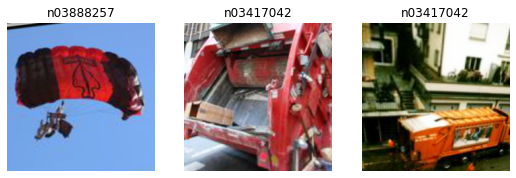

In [14]:
dls.show_batch(nrows=1,ncols=3)

In [16]:
model = xresnet50()
learn = Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy)

In [17]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.691558,2.133393,0.440627,00:54
1,1.297303,1.776947,0.482823,00:51
2,1.007589,1.565406,0.540329,00:51
3,0.800981,0.806149,0.750187,00:51
4,0.662568,0.629558,0.801344,00:51


### Normalize with ImageNet stats
- especially important with pretrained models (use their normalization technique) 
- cnn_learner automatically does this for pretrained models
- mean 0, std 1 desired (also a reason for using Batch Norm inside our net !

In [23]:
x.shape

torch.Size([64, 3, 224, 224])

In [22]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3])  #do not normalize over channel axis (axis 1)
x.std(dim=[0,2,3])

TensorImage([0.2663, 0.2590, 0.2786], device='cuda:0')

In [4]:
def get_dls(bs,size): 
    dblock = DataBlock(blocks=(ImageBlock(),CategoryBlock()), 
        get_items = get_image_files, 
        get_y = parent_label, 
        item_tfms = Resize(460), 
        batch_tfms=[*aug_transforms(size=224,min_scale=0.75), Normalize.from_stats(*imagenet_stats)]) 
    return dblock.dataloaders(path,bs=bs)

In [5]:
dls = get_dls (64,224)

In [26]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3])
x.std(dim=[0,2,3])


TensorImage([1.1628, 1.1590, 1.2795], device='cuda:0')

In [7]:
model = xresnet50()
learn = Learner(dls,model,loss_func=CrossEntropyLossFlat(),metrics=accuracy)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0008317637839354575)

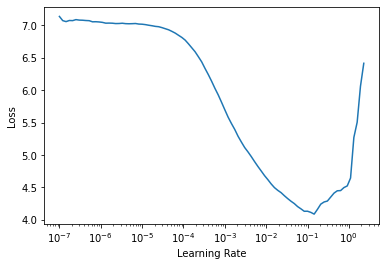

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(5,lr_max=slice(5e-3,5e-1))

epoch,train_loss,valid_loss,accuracy,time
0,3.828979,1020817.125000,0.097087,00:50
1,3.094650,2.332667,0.097461,00:51
2,2.580533,2.305938,0.106796,00:51
3,2.289441,2.256141,0.140777,00:51
4,2.236566,2.234620,0.168783,00:51


## Progressive Resizing 
- start training with smaller images, then steadily increase size and train with larger images
- allows for fast speed + good accuracy
- form of data augmentation 
- intuition : form of transfer learning 
- first train for a few epochs with smaller images, then use larger ones 
- might hurt performance for transfer learning, due to pretrained model task being very similar to use case => try it !

In [6]:
dls = get_dls(32,128)
learn = Learner(dls,xresnet50(),loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.650219,3.104120,0.368559,00:56
1,1.201384,1.422922,0.540702,00:54
2,0.903254,0.786530,0.759522,00:55
3,0.715917,0.659044,0.798357,00:55


In [7]:
learn.dls = get_dls(32,224)
learn.fine_tune(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.756739,0.824112,0.742345,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.665086,0.650766,0.794996,00:55
1,0.625068,0.685953,0.783047,00:55
2,0.584132,0.532789,0.834578,00:55
3,0.521041,0.508942,0.837565,00:55
4,0.488484,0.481387,0.846527,00:55


### Test time augmentation (TTA) 
- apply the augmentation on the validation set for testing
- create multiple versions of each image for testing purposes
- take average or maximum of the predictions for each augmented version of the image
- fastai uses unaugmented center crop + 4 randomly augmented images


In [8]:
preds, targs = learn.tta()
accuracy(preds,targs).item()

0.855862557888031

## Mixup
- selects another image and creates a new image by weighting the original image and addding the other one       
=> weighted average of images as independent variable          
=> weighted average of labels as dependent variable                  
- can be done by adding a callback 
- amount of mixup influences how close label is to 0 or 1 => depends on data augmentation => label smoothing to combat this 

In [10]:
model = xresnet50()
learn = Learner(dls,model,loss_func=CrossEntropyLossFlat(),
               metrics=accuracy,cbs=Mixup)  #Mixup only works with Fastai1 currently
learn.fit_one_cycle(5,3e-3)

NameError: name 'Mixup' is not defined

## Label Smoothing
- assume that labels are never perfect, reduce label of 1 to something slightly less than 1 
=> more robust against noisy labels, better generalization and performance @ inference 
- replace 0s with : 
$$\epsilon/N$$
- N : # of classes, epsilon : smoothing hyperparameter, mostly choosen as 0.1  
- replace 1s with : $$1 - \epsilon + \frac{\epsilon}{N}$$
=> model is not overconfident 
- use : 
```python 
LabelSmoothingCrossEntropy()
```
to use label smoothing 
- helps especially with more epochs 